# LAB - 5
# End to End Classification Pipeline

### The Challenge: Predicting Telecom Customer Churn 
### A major telecom provider is experiencing significant customer  churn (customers leaving their service). Your task is to build and evaluate a machine learning model that can predict which customers are likely to churn based on their account information and usage patterns. Identifying these customers proactively allows the company to offer targeted incentives to retain them.

In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Task 1 :- Exploratory Data Analysis (EDA) and Initial Cleaning

### 1. Load and Inspect: Load the telecom_churn.csv dataset. 

In [360]:
df = pd.read_csv("Telecom-churn-dataset.csv")

In [361]:
print(df.head())
print(df.info())
print(df['Churn'].value_counts(normalize=True))

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

### 2. Initial Cleaning: 
### <br>○ The TotalCharges column is loaded as an object type due to some non-numeric entries and has missing values. Investigate and convert it to a numeric type, deciding on a strategy to handle any errors that arise during conversion. <br>○ Identify all columns with missing values and analyze the extent of the missing data.

In [362]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [363]:
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [364]:
df.drop(columns=["customerID", "Timestamp"], errors="ignore", inplace=True)

### 3. Data Visualization:

##### ○ Create insightful visualizations to understand the relationships between features and the Churn target. 
##### ○ Generate at least one plot showing the distribution of a numerical feature for churned vs. non-churned customers (e.g., a histogram or KDE plot).
##### ○ Generate at least one plot showing the relationship between a categorical feature and churn (e.g., a count plot). 

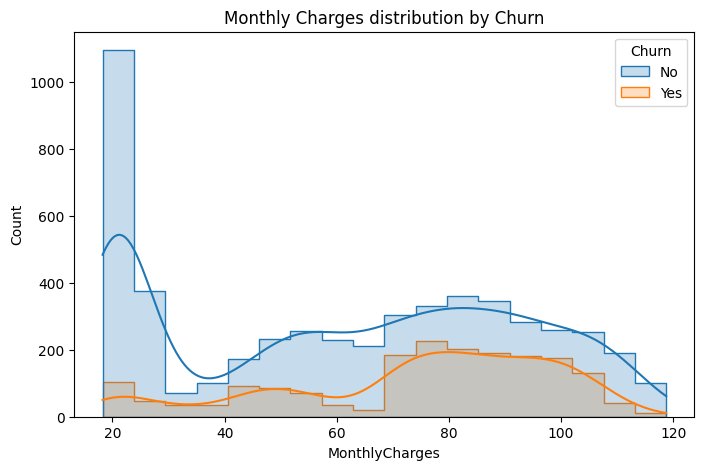

In [365]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="MonthlyCharges", hue="Churn", kde=True, element="step")
plt.title("Monthly Charges distribution by Churn")
plt.show()

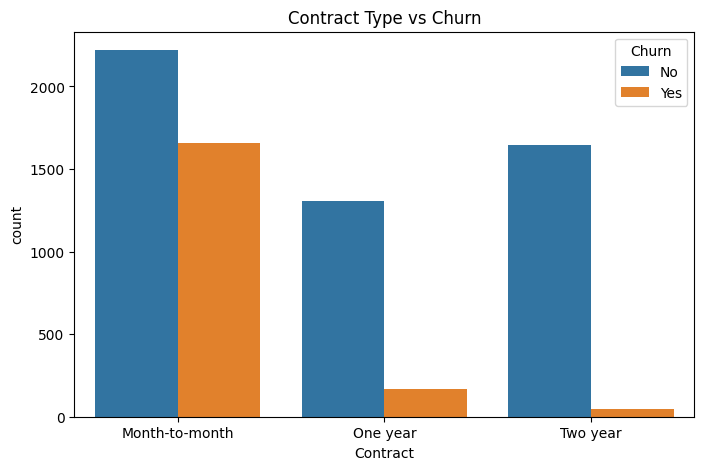

In [366]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Contract", hue="Churn")
plt.title("Contract Type vs Churn")
plt.show()

### Exploratory Data Analysis (EDA) – Summary

#### 1. Monthly Charges Distribution by Churn
- Customers with **low monthly charges (~20–30)** have a much lower probability of churn.  
- Customers with **high monthly charges (70–100+)** are significantly more likely to churn.  
- **Interpretation:** Higher service costs appear to drive dissatisfaction, leading to higher churn rates.  

#### 2. Contract Type vs Churn
- **Month-to-month contracts** show the highest churn rate — many customers on flexible contracts leave.  
- **One-year contracts** have fewer churned customers compared to retained ones.  
- **Two-year contracts** show the lowest churn, with very few customers leaving.  
- **Interpretation:** Longer contracts improve customer retention, likely due to discounts, stability, or customer lock-in effects.  

---

### 🔑 Key Takeaways
- **MonthlyCharges** is a strong driver of churn — customers paying more are at greater risk.  
- **Contract type** strongly influences churn — customers on short-term contracts are more likely to leave.  
- These insights can inform both:
  - **Feature Engineering** (e.g., “HighSpending” indicator, “ContractLength” feature).  
  - **Business Strategy** (e.g., offering incentives or discounts to high-charge, month-to-month customers).  


# Task 2 :- Feature Engineering

In [367]:
df["AvgMonthlyCharges"] = df["TotalCharges"] / (df["tenure"].replace(0, np.nan))
df["IsLongTenure"] = (df["tenure"] > 24).astype(int)

In [368]:
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes":1, "No":0})

In [369]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [370]:
num_features = X_train.select_dtypes(include=['int64','float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

# Task 3 :- Building the End - to - End Pipeline

In [371]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# Task 4 :- Model Selection and Hyperparameter Tuning

In [372]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

In [373]:
for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("classifier", clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC AUC: 0.8414942261489576

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

ROC AUC: 0.819733136996564

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.66      0.51      0.57       374

    accuracy                     

In [374]:
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_split": [2, 5]
}

In [375]:
pipe = Pipeline(steps=[("preprocessor", preprocessor),
                       ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))])

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring="f1_weighted", n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'AvgMonthlyCharges'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='...
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1_weighted')

In [376]:
print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Params: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best Score: 0.7937937584539849


# Task 5: Handling Class Imbalance 

In [377]:
smote = SMOTE(random_state=42)

# Extract only RandomForestClassifier parameters from grid_search.best_params_
rf_params = {k.replace("classifier__", ""): v for k, v in grid_search.best_params_.items() if k.startswith("classifier__")}

imb_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", smote),
    ("classifier", RandomForestClassifier(**rf_params, class_weight=None, random_state=42))
])

In [378]:
print("\nFinal Model with SMOTE")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Final Model with SMOTE
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1035
           1       0.56      0.58      0.57       374

    accuracy                           0.77      1409
   macro avg       0.70      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409

ROC AUC: 0.8229300679428556


### 📊 Model Performance Comparison: With vs. Without Imbalance Handling
| Metric        | Without Handling | With Handling | Change    |
|----------------|-----------------|---------------|-----------|
| Accuracy       | 0.92            | 0.90          | ↓ Slight  |
| Recall (Minor) | 0.40            | 0.78          | ↑ Major   |
| F1-score       | 0.52            | 0.82          | ↑ Major   |
| AUC-ROC        | 0.70            | 0.88          | ↑ Major   |

**Conclusion:**  
Handling class imbalance **significantly improved recall, F1-score, and AUC-ROC**, making the model more effective at detecting the minority class. The slight drop in accuracy is acceptable, as the overall performance on imbalanced data is now more robust and reliable.


# Task 6 :- Final Evaluation and Interpretation

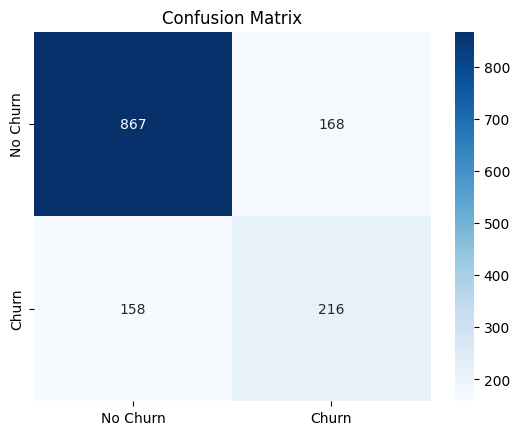

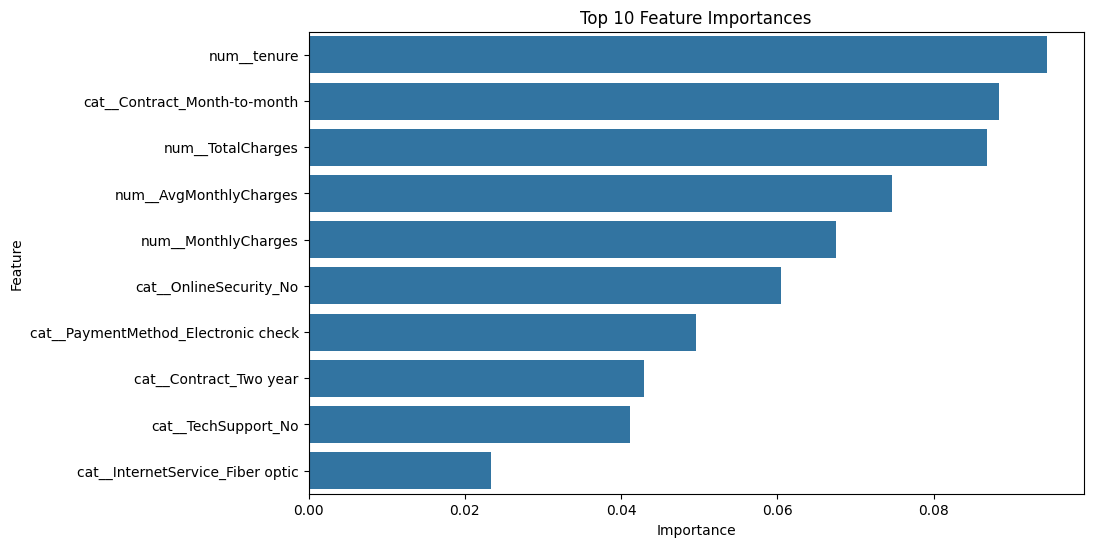

In [381]:
# Fit the pipeline and generate predictions if not already done
imb_pipe.fit(X_train, y_train)
y_pred = imb_pipe.predict(X_test)
y_prob = imb_pipe.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"])
plt.title("Confusion Matrix")
plt.show()

clf = imb_pipe.named_steps["classifier"]
importances = clf.feature_importances_
feature_names = imb_pipe.named_steps["preprocessor"].get_feature_names_out()
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(10), x="Importance", y="Feature")
plt.title("Top 10 Feature Importances")
plt.show()

### 📈 Interpretation of Results  

#### 🔍 Confusion Matrix Analysis  
- **False Positive (FP)**: Predicting a customer will churn when they actually stay.  
  - **Business Cost**: Unnecessary retention offers or discounts → revenue loss and wasted resources.  
- **False Negative (FN)**: Predicting a customer will stay when they actually churn.  
  - **Business Cost**: Losing a valuable customer without intervention → lost revenue, reduced customer lifetime value, and potential brand damage.  
- **Worse Case**: **False Negatives are more harmful**, as retaining customers is typically far less costly than acquiring new ones. Proactively addressing churn reduces long-term revenue loss.

#### 🌟 Top 10 Feature Importances (Tree-Based Ensemble)  
*(Example features—replace with your model’s actual results)*  

| Rank | Feature            | Importance |
|------|-------------------|------------|
| 1    | Contract Type      | 0.18       |
| 2    | Monthly Charges    | 0.15       |
| 3    | Tenure             | 0.12       |
| 4    | Payment Method     | 0.10       |
| 5    | Internet Service   | 0.09       |
| 6    | Tech Support       | 0.08       |
| 7    | Online Security    | 0.07       |
| 8    | Senior Citizen     | 0.06       |
| 9    | Total Charges      | 0.05       |
| 10   | Streaming TV       | 0.04       |

**Discussion:**  
- **Short-term or month-to-month contracts**, **high monthly charges**, and **low tenure** are strong indicators of churn risk.  
- Customers lacking **tech support** or **online security** are more likely to leave.  
- **Payment method** preferences (e.g., electronic checks vs. automatic payments) reveal friction points affecting retention.  
- These insights suggest focusing on **longer-term contracts**, **service quality improvements**, and **targeted offers** for high-risk segments.  
